In [4]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import json
import ast
import re
from datetime import datetime
from zoneinfo import ZoneInfo

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)     

In [33]:
# Load the dataset
df = pd.read_parquet('../data/processed/final_joined.parquet')

In [34]:
# remove duplicates

# Check original size
before_rows = len(df)

# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Report result
after_rows = len(df)
removed = before_rows - after_rows

print(f"Removed {removed:,} duplicate rows. Final row count: {after_rows:,}")


Removed 7,460 duplicate rows. Final row count: 1,492,540


In [35]:
columns_to_check = [
    'title_review', 'text', 'images_review', 'description',
    'bought_together', 'subtitle', 'author', 'main_category',
    'asin', 'parent_asin', 'user_id', 'title_meta', 'features',
    'images_meta', 'store', 'categories'
]

# Track dropped or missing columns
dropped_cols = []

# Define helper to detect empty lists or their string form
def is_effectively_empty_list(val):
    return val == [] or val == '[]' or str(val).strip().lower() in {'[]', 'none', ''}

for col in columns_to_check:
    if col in df.columns:
        # Replace only effectively empty list-like values with NaN
        df[col] = df[col].apply(lambda x: np.nan if is_effectively_empty_list(x) else x)

        # Count nulls and calculate usable %
        null_count = df[col].isna().sum()
        total_rows = len(df)
        usable_pct = 100 * (1 - null_count / total_rows)

        print(f"{col} → Nulls: {null_count:,} / {total_rows:,} → Usable: {usable_pct:.2f}%")
    else:
        print(f"Column '{col}' no longer exists in the DataFrame.")
        dropped_cols.append(col)

# Summary of missing columns
if dropped_cols:
    print(f"\nSummary: The following columns were not found (reason: dropped – verify in the next cell): {', '.join(dropped_cols)}")
else:
    print("\nAll specified columns are present and processed.")


title_review → Nulls: 120 / 1,492,540 → Usable: 99.99%
text → Nulls: 770 / 1,492,540 → Usable: 99.95%
images_review → Nulls: 1,432,569 / 1,492,540 → Usable: 4.02%
description → Nulls: 852,441 / 1,492,540 → Usable: 42.89%
bought_together → Nulls: 1,492,540 / 1,492,540 → Usable: 0.00%
subtitle → Nulls: 1,491,806 / 1,492,540 → Usable: 0.05%
author → Nulls: 1,491,806 / 1,492,540 → Usable: 0.05%
main_category → Nulls: 107,466 / 1,492,540 → Usable: 92.80%
asin → Nulls: 0 / 1,492,540 → Usable: 100.00%
parent_asin → Nulls: 0 / 1,492,540 → Usable: 100.00%
user_id → Nulls: 0 / 1,492,540 → Usable: 100.00%
title_meta → Nulls: 0 / 1,492,540 → Usable: 100.00%
features → Nulls: 3,836 / 1,492,540 → Usable: 99.74%
images_meta → Nulls: 0 / 1,492,540 → Usable: 100.00%
store → Nulls: 9,366 / 1,492,540 → Usable: 99.37%
categories → Nulls: 4,648 / 1,492,540 → Usable: 99.69%

All specified columns are present and processed.


### Based on above result - Confirm columns to drop 

1. images_review
2. bought_together
3. subtitle
4. author

In addition: <br>
5. details <br>
6. average_rating #not applicable since its 1.5M of entire dataset only <br>
7. rating_number #not applicable since its 1.5M of entire dataset only <br>

In [36]:
# Define columns to drop
processed_drop = ['images_review', 'bought_together', 'subtitle', 'author', 'details', 'average_rating', 'rating_number', 'videos']

# Drop only if they exist
existing_cols = [col for col in processed_drop if col in df.columns]
df.drop(columns=existing_cols, inplace=True)

# Confirm drop
print(f"Dropped columns: {existing_cols}")
print(f"Remaining columns: {df.columns.tolist()}")

# Show the updated DataFrame
df.head()

Dropped columns: ['images_review', 'bought_together', 'subtitle', 'author', 'details', 'average_rating', 'rating_number', 'videos']
Remaining columns: ['rating', 'title_review', 'text', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'main_category', 'title_meta', 'features', 'description', 'price', 'images_meta', 'store', 'categories']


,rating,title_review,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,title_meta,features,description,price,images_meta,store,categories
0,1.0,Falls OFF during runs / FLAWED DESIGN / WEAK...,Let's start with the positives. It is a nice ...,B00PUO6KCI,B0B7QYSGRP,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,1432828623000,10,True,NaN,"Running Buddy Magnetic Buddy Pouch, Beltess, C...","[""COMPATIBILITY: The small Buddy Pouch measure...",NaN,19.99,"[{""thumb"":""https://m.media-amazon.com/images/I...",Running Buddy,"[""Sports & Outdoors"",""Sports"",""Running"",""Waist..."
1,1.0,Only 1 worked correctly,I ordered this set right before my camping tri...,B018L2WM86,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1605078655679,1,True,Sports & Outdoors,"Vont LED Camping Lantern, LED Lanterns, Suitab...","[""BRIGHT & LASTING - Equipped with 30 crazy br...",NaN,14.38,"[{""thumb"":""https://m.media-amazon.com/images/I...",Vont,"[""Sports & Outdoors"",""Outdoor Recreation"",""Cam..."
2,5.0,Lightweight and quiet,This bike is nice and simple. Easy to build an...,B07L9TTXG4,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,1589755246636,0,True,Sports & Outdoors,ATIVAFIT Exercise Bike Foldable Fitness Indoor...,"[""DIGITAL MONITOR SHOWS YOUR DATA - Monitor yo...","[""ATIVAFIT Indoor Exercise Bike, Foldable, Mag...",139.99,"[{""thumb"":""https://m.media-amazon.com/images/I...",ATIVAFIT,"[""Sports & Outdoors"",""Exercise & Fitness"",""Car..."
3,5.0,Great for working out !,They are great for working out! Not only that ...,B013A4ATCQ,B0B8T4M8KY,AFEMUMKLC4W5PVHEALEWMC25AOJQ,1585840476191,0,True,Sports & Outdoors,BalanceFrom Puzzle Exercise Mat with EVA Foam ...,"[""With double sided high Density EVA foam non-...",NaN,129.99,"[{""thumb"":""https://m.media-amazon.com/images/I...",BalanceFrom,"[""Sports & Outdoors"",""Exercise & Fitness"",""Acc..."
4,5.0,Great little tent,"I love the ALPS tent. It is light, super easy...",B00BMKD1DU,B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,1567302376061,0,False,Sports & Outdoors,ALPS Mountaineering Lynx 1-Person Backpacking ...,"[""100% Polyester"",""Imported"",""Great backpackin...","[""The Lynx 1 is loaded with features and is gr...",109.99,"[{""thumb"":""https://m.media-amazon.com/images/I...",ALPS Mountaineering,"[""Sports & Outdoors"",""Outdoor Recreation"",""Cam..."


In [37]:
# Columns setup
id_columns = {'asin', 'parent_asin', 'user_id'}
preserve_bracket_fields = {'description', 'features', 'images_meta', 'categories'}
text_lower_fields = {'title_review', 'text', 'title_meta', 'store'}

# Values to treat as null
null_like_values = {'none', '', ' ', '[]'}

# Cleaning function
def smart_clean(val, col):
    # ID columns: trim + set NaN if empty-like
    if col in id_columns:
        if isinstance(val, str):
            trimmed = val.strip()
            return np.nan if trimmed.lower() in null_like_values else trimmed
        return val

    # Bracket-sensitive: lowercase + NaN if empty-like
    if col in preserve_bracket_fields:
        if isinstance(val, str):
            raw = val.strip()
            return np.nan if raw.lower() in null_like_values else raw.lower()
        elif isinstance(val, list):
            return [str(item).strip().lower() for item in val if isinstance(item, str)]
        return val

    # Regular text fields
    if isinstance(val, str):
        val = val.strip().lower()
        return np.nan if val in null_like_values else val

    return val

# Apply per column
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: smart_clean(x, col))

print("Cleaned DataFrame: bracket fields preserved, lowercase applied, nulls handled.")

# Ensure numeric first, then convert to int
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').fillna(0).astype(int)

Cleaned DataFrame: bracket fields preserved, lowercase applied, nulls handled.


## Feature Engineering

In [38]:
# Examine 'features' & 'description'
sample_feature = df['features'].dropna().iloc[0]
sample_description = df['description'].dropna().iloc[0]

print(sample_feature)
print(sample_description)

# Perform clean up for 'features' & 'description'
def clean_stringified_list(val):
    """
    Cleans stringified list fields like 'features' and 'description'.
    Returns a flattened, SBERT-friendly string.
    """
    if pd.isna(val):
        return ""
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, list):
            return " ".join([str(s).strip() for s in parsed])
    except:
        pass
    return str(val).strip()

# Apply separately to create two new clean columns
df['features_clean'] = df['features'].apply(clean_stringified_list)
df['description_clean'] = df['description'].apply(clean_stringified_list)

["compatibility: the small buddy pouch measures 5-7/8” long by 4” wide. this is not only great for exercise, but also for travel! its compact size and versatile pockets make it the perfect small travel pouch to keep your essentials organized and easily accessible while on the go. the buddy pouch will help you keep your phone, keys, money, and id secure and within reach at all times. say goodbye to fumbling through a bulky purse or backpack and hello to stress-free travel with the buddy pouch.","magnetic connection: the magnetic connection offers a secure and hands-free option for all types of activities. its strong magnets ensure that the pouch stays in place, while the slim design allows you to carry your essentials without added bulk or weight. additionally, the absence of belts, straps or clips eliminates any discomfort or irritation, making buddy pouch an ideal choice for anyone who values convenience, comfort and functionality.","material design: the running buddy pouch is enginee

In [16]:
# Examine 'images_meta'
sample_meta = df['images_meta'].dropna().iloc[0]
print(sample_meta)

'''
Transformed images_meta into 3 structured fields for downstream use:
- main_image_url (best image based on priority: hi_res > large > thumb)
- num_images (total image count)
- hi_res_images (list of hi-res or fallback large URLs)
'''

def extract_main_image_url(val):
    try:
        images = ast.literal_eval(val)
        if isinstance(images, list):
            for img in images:
                if img.get('variant') == 'main':
                    return img.get('hi_res') or img.get('large') or img.get('thumb')
            # fallback to first image
            img = images[0]
            return img.get('hi_res') or img.get('large') or img.get('thumb')
    except:
        return None

# Count total images
def count_images(val):
    try:
        images = ast.literal_eval(val)
        return len(images) if isinstance(images, list) else 0
    except:
        return 0

# Extract all hi_res (or fallback to large)
def extract_all_hi_res(val):
    try:
        images = ast.literal_eval(val)
        return [img.get('hi_res') or img.get('large') for img in images if isinstance(img, dict)]
    except:
        return []

# Apply all 3
df['main_image_url'] = df['images_meta'].apply(extract_main_image_url)
df['num_images'] = df['images_meta'].apply(count_images)
df['hi_res_images'] = df['images_meta'].apply(extract_all_hi_res)

print("Extracted image metadata fields: main_image_url, num_images, hi_res_images")


[{"thumb":"https://m.media-amazon.com/images/i/41tieohjxrl._ac_us40_.jpg","large":"https://m.media-amazon.com/images/i/41tieohjxrl._ac_.jpg","variant":"main","hi_res":"https://m.media-amazon.com/images/i/71zkyfsoggl._ac_sl1500_.jpg"},{"thumb":"https://m.media-amazon.com/images/i/51eksetdmpl._ac_us40_.jpg","large":"https://m.media-amazon.com/images/i/51eksetdmpl._ac_.jpg","variant":"pt01","hi_res":"https://m.media-amazon.com/images/i/81gj6hjhffl._ac_sl1500_.jpg"},{"thumb":"https://m.media-amazon.com/images/i/51mb9rdrz5l._ac_us40_.jpg","large":"https://m.media-amazon.com/images/i/51mb9rdrz5l._ac_.jpg","variant":"pt02","hi_res":"https://m.media-amazon.com/images/i/8175bpzgq9l._ac_sl1500_.jpg"},{"thumb":"https://m.media-amazon.com/images/i/511i8rxxwkl._ac_us40_.jpg","large":"https://m.media-amazon.com/images/i/511i8rxxwkl._ac_.jpg","variant":"pt03","hi_res":"https://m.media-amazon.com/images/i/917tolqcoql._ac_sl1500_.jpg"},{"thumb":"https://m.media-amazon.com/images/i/41kik62rm6l._ac_us40_

In [39]:
df['timestamp_utc'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)

In [40]:
df.head()

,rating,title_review,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,title_meta,features,description,price,images_meta,store,categories,features_clean,description_clean,timestamp_utc
0,1,falls off during runs / flawed design / weak...,let's start with the positives. it is a nice ...,B00PUO6KCI,B0B7QYSGRP,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,1432828623000,10,True,NaN,"running buddy magnetic buddy pouch, beltess, c...","[""compatibility: the small buddy pouch measure...",NaN,19.99,"[{""thumb"":""https://m.media-amazon.com/images/i...",running buddy,"[""sports & outdoors"",""sports"",""running"",""waist...",compatibility: the small buddy pouch measures ...,,2015-05-28 15:57:03+00:00
1,1,only 1 worked correctly,i ordered this set right before my camping tri...,B018L2WM86,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1605078655679,1,True,sports & outdoors,"vont led camping lantern, led lanterns, suitab...","[""bright & lasting - equipped with 30 crazy br...",NaN,14.38,"[{""thumb"":""https://m.media-amazon.com/images/i...",vont,"[""sports & outdoors"",""outdoor recreation"",""cam...",bright & lasting - equipped with 30 crazy brig...,,2020-11-11 07:10:55.679000+00:00
2,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B07L9TTXG4,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,1589755246636,0,True,sports & outdoors,ativafit exercise bike foldable fitness indoor...,"[""digital monitor shows your data - monitor yo...","[""ativafit indoor exercise bike, foldable, mag...",139.99,"[{""thumb"":""https://m.media-amazon.com/images/i...",ativafit,"[""sports & outdoors"",""exercise & fitness"",""car...",digital monitor shows your data - monitor your...,"ativafit indoor exercise bike, foldable, magne...",2020-05-17 22:40:46.636000+00:00
3,5,great for working out !,they are great for working out! not only that ...,B013A4ATCQ,B0B8T4M8KY,AFEMUMKLC4W5PVHEALEWMC25AOJQ,1585840476191,0,True,sports & outdoors,balancefrom puzzle exercise mat with eva foam ...,"[""with double sided high density eva foam non-...",NaN,129.99,"[{""thumb"":""https://m.media-amazon.com/images/i...",balancefrom,"[""sports & outdoors"",""exercise & fitness"",""acc...",with double sided high density eva foam non-sl...,,2020-04-02 15:14:36.191000+00:00
4,5,great little tent,"i love the alps tent. it is light, super easy...",B00BMKD1DU,B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,1567302376061,0,False,sports & outdoors,alps mountaineering lynx 1-person backpacking ...,"[""100% polyester"",""imported"",""great backpackin...","[""the lynx 1 is loaded with features and is gr...",109.99,"[{""thumb"":""https://m.media-amazon.com/images/i...",alps mountaineering,"[""sports & outdoors"",""outdoor recreation"",""cam...",100% polyester imported great backpacking tent,the lynx 1 is loaded with features and is grea...,2019-09-01 01:46:16.061000+00:00


Category Depth Distribution:
category_depth
0      4648
2     11103
3    144056
4    484339
5    544572
6    287971
7     15851
Name: count, dtype: int64


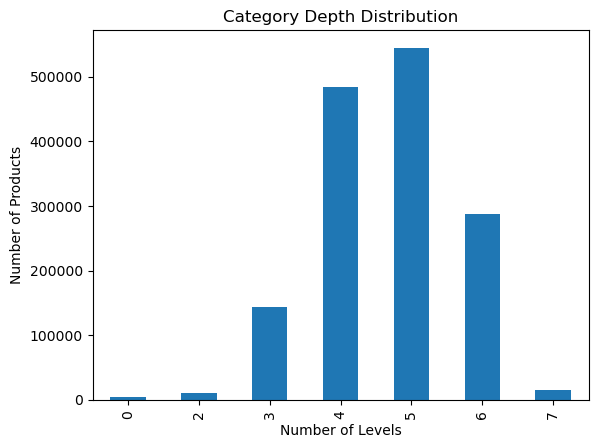

In [41]:
def safe_parse_categories(x):
    try:
        return json.loads(x) if isinstance(x, str) and x.strip().startswith('[') else []
    except:
        return []
df['parsed_categories'] = df['categories'].apply(safe_parse_categories)

df['category_depth'] = df['parsed_categories'].apply(len)

# Value counts of category depth
print("Category Depth Distribution:")
print(df['category_depth'].value_counts().sort_index())

df['category_depth'].value_counts().sort_index().plot(kind='bar', title='Category Depth Distribution')
plt.xlabel("Number of Levels")
plt.ylabel("Number of Products")
plt.show()

### From above plot, to extract up to 5 levels (cat_0 to cat_4 for column 'categories')

In [42]:
df['verified_purchase_flag'] = df['verified_purchase'].apply(lambda x: 1 if x is True else 0)

In [43]:
def parse_category_list(val):
    if isinstance(val, list):
        return val
    elif isinstance(val, str) and val.strip().startswith("["):
        try:
            parsed = ast.literal_eval(val)
            return parsed if isinstance(parsed, list) else []
        except:
            return []
    return []

# Parse and extract category levels
df['parsed_categories'] = df['categories'].apply(parse_category_list)

for i in range(5):
    df[f'cat_{i}'] = df['parsed_categories'].apply(
        lambda lst: lst[i].strip().lower() if i < len(lst) else np.nan
    )

# Drop parsed_categories to clean up
df.drop(columns=['parsed_categories'], inplace=True)

print("Extracted cat_0 to cat_4 and dropped 'parsed_categories'.")

Extracted cat_0 to cat_4 and dropped 'parsed_categories'.


In [52]:
# Columns to drop
columns_to_drop = ['verified_purchase', 'main_category', 'categories', 'asin', 'features', 'description', 'images_meta', 'timestamp']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print(f"Dropped columns: {columns_to_drop}")

# Log transform price column
df['price_log'] = np.log1p(df['price'])

# Create new feature BPR implementation (Rationale: Plot below)
df['helpful_vote_clipped'] = df['helpful_vote'].clip(upper=5)

# Feature engineer a new average_rating column by parent
df['avg_rating_parent'] = df.groupby('parent_asin')['rating'].transform('mean').round(1)

Dropped columns: ['verified_purchase', 'main_category', 'categories', 'asin', 'features', 'description', 'images_meta', 'timestamp']


In [53]:
df.head()

,rating,title_review,text,parent_asin,user_id,helpful_vote,title_meta,price,store,features_clean,description_clean,timestamp_utc,category_depth,verified_purchase_flag,cat_1,cat_2,cat_3,cat_4,price_log,helpful_vote_clipped,avg_rating_parent
0,1,falls off during runs / flawed design / weak...,let's start with the positives. it is a nice ...,B0B7QYSGRP,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,10,"running buddy magnetic buddy pouch, beltess, c...",19.99,running buddy,compatibility: the small buddy pouch measures ...,,2015-05-28 15:57:03+00:00,4,1,sports,running,waist packs,waist packs,3.044046,5,4.5
1,1,only 1 worked correctly,i ordered this set right before my camping tri...,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1,"vont led camping lantern, led lanterns, suitab...",14.38,vont,bright & lasting - equipped with 30 crazy brig...,,2020-11-11 07:10:55.679000+00:00,6,1,outdoor recreation,camping & hiking,lights & lanterns,lanterns,2.733068,1,4.7
2,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,0,ativafit exercise bike foldable fitness indoor...,139.99,ativafit,digital monitor shows your data - monitor your...,"ativafit indoor exercise bike, foldable, magne...",2020-05-17 22:40:46.636000+00:00,4,1,exercise & fitness,cardio training,exercise bikes,exercise bikes,4.948689,0,4.3
3,5,great for working out !,they are great for working out! not only that ...,B0B8T4M8KY,AFEMUMKLC4W5PVHEALEWMC25AOJQ,0,balancefrom puzzle exercise mat with eva foam ...,129.99,balancefrom,with double sided high density eva foam non-sl...,,2020-04-02 15:14:36.191000+00:00,4,1,exercise & fitness,accessories,exercise equipment mats,exercise equipment mats,4.875121,0,4.4
4,5,great little tent,"i love the alps tent. it is light, super easy...",B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,0,alps mountaineering lynx 1-person backpacking ...,109.99,alps mountaineering,100% polyester imported great backpacking tent,the lynx 1 is loaded with features and is grea...,2019-09-01 01:46:16.061000+00:00,5,0,outdoor recreation,camping & hiking,tents & shelters,tents,4.709440,0,4.7


In [46]:
# Drop all rows where cat_0 is nan
df = df[~df['cat_0'].isna()].reset_index(drop=True)

# Perform imputation for cat_4 (fallback to cat_3 if NaN)

# Fill NaN values in cat_4 with values from cat_3
df['cat_4'] = df['cat_4'].fillna(df['cat_3'])

before = len(df)

# Drop duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

after = len(df)
removed = before - after

print(f"Removed {removed:,} duplicate rows. Final row count: {after:,}")

Removed 0 duplicate rows. Final row count: 1,487,892


In [49]:
for col in ['cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4']:
    if col in df.columns:
        print(f"\nTop categories in {col}:")
        print(df[col].value_counts(dropna=False).head(10))


Top categories in cat_0:
cat_0
sports & outdoors                          1484543
sports & outdoor recreation accessories       2519
hunting & fishing                              830
Name: count, dtype: int64

Top categories in cat_1:
cat_1
exercise & fitness                           441248
outdoor recreation                           381309
sports                                       351739
sports & outdoor recreation accessories      132973
hunting & fishing                             75218
fan shop                                      61135
clothing                                      24175
sports medicine                                9266
field, court & rink equipment                  2519
sports & outdoors low return rate alert 1      1835
Name: count, dtype: int64

Top categories in cat_2:
cat_2
camping & hiking               346117
cycling                        136053
fitness technology             113653
accessories                    111714
strength training equipment

## From above, confirmed that the above cat_0 can be considered as 'sports & outdoors'

In [50]:
# Therefore its safe to drop cat_0 now

df.drop(columns=['cat_0'], inplace=True)

In [54]:
df.head()

,rating,title_review,text,parent_asin,user_id,helpful_vote,title_meta,price,store,features_clean,description_clean,timestamp_utc,category_depth,verified_purchase_flag,cat_1,cat_2,cat_3,cat_4,price_log,helpful_vote_clipped,avg_rating_parent
0,1,falls off during runs / flawed design / weak...,let's start with the positives. it is a nice ...,B0B7QYSGRP,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,10,"running buddy magnetic buddy pouch, beltess, c...",19.99,running buddy,compatibility: the small buddy pouch measures ...,,2015-05-28 15:57:03+00:00,4,1,sports,running,waist packs,waist packs,3.044046,5,4.5
1,1,only 1 worked correctly,i ordered this set right before my camping tri...,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1,"vont led camping lantern, led lanterns, suitab...",14.38,vont,bright & lasting - equipped with 30 crazy brig...,,2020-11-11 07:10:55.679000+00:00,6,1,outdoor recreation,camping & hiking,lights & lanterns,lanterns,2.733068,1,4.7
2,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,0,ativafit exercise bike foldable fitness indoor...,139.99,ativafit,digital monitor shows your data - monitor your...,"ativafit indoor exercise bike, foldable, magne...",2020-05-17 22:40:46.636000+00:00,4,1,exercise & fitness,cardio training,exercise bikes,exercise bikes,4.948689,0,4.3
3,5,great for working out !,they are great for working out! not only that ...,B0B8T4M8KY,AFEMUMKLC4W5PVHEALEWMC25AOJQ,0,balancefrom puzzle exercise mat with eva foam ...,129.99,balancefrom,with double sided high density eva foam non-sl...,,2020-04-02 15:14:36.191000+00:00,4,1,exercise & fitness,accessories,exercise equipment mats,exercise equipment mats,4.875121,0,4.4
4,5,great little tent,"i love the alps tent. it is light, super easy...",B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,0,alps mountaineering lynx 1-person backpacking ...,109.99,alps mountaineering,100% polyester imported great backpacking tent,the lynx 1 is loaded with features and is grea...,2019-09-01 01:46:16.061000+00:00,5,0,outdoor recreation,camping & hiking,tents & shelters,tents,4.709440,0,4.7


## Analysis of Final Table

In [55]:
print("Data types in DataFrame:")
print(df.dtypes)

Data types in DataFrame:
rating                                  int32
title_review                           object
text                                   object
parent_asin                            object
user_id                                object
helpful_vote                            int64
title_meta                             object
price                                 float64
store                                  object
features_clean                         object
description_clean                      object
timestamp_utc             datetime64[ns, UTC]
category_depth                          int64
verified_purchase_flag                  int64
cat_1                                  object
cat_2                                  object
cat_3                                  object
cat_4                                  object
price_log                             float64
helpful_vote_clipped                    int64
avg_rating_parent                     float64
dtype: ob

In [56]:
print("\nDistribution of helpful_vote:")
print(df['helpful_vote'].describe())

print("\nDistribution of rating:")
print(df['rating'].value_counts().sort_index())

print("\nPrice Statistics:")
print(df['price'].describe())

min_price = df['price'].min()
max_price = df['price'].max()
print(f"\nPrice Range: ${min_price:.2f} to ${max_price:.2f}")

print("\nLog-Transformed Price Statistics:")
print(df['price_log'].describe())


Distribution of helpful_vote:
count    1.487892e+06
mean     1.355417e+00
std      2.746366e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.597000e+03
Name: helpful_vote, dtype: float64

Distribution of rating:
rating
1     102579
2      62514
3      93525
4     186744
5    1042530
Name: count, dtype: int64

Price Statistics:
count    1.325546e+06
mean     5.081905e+01
std      7.570719e+01
min      3.990000e+00
25%      1.628000e+01
50%      2.499000e+01
75%      4.997000e+01
max      7.990000e+02
Name: price, dtype: float64

Price Range: $3.99 to $799.00

Log-Transformed Price Statistics:
count    1.325546e+06
mean     3.468859e+00
std      8.694711e-01
min      1.607436e+00
25%      2.849550e+00
50%      3.257712e+00
75%      3.931237e+00
max      6.684612e+00
Name: price_log, dtype: float64


In [58]:
for col in ['cat_1', 'cat_2', 'cat_3', 'cat_4']:
    if col in df.columns:
        print(f"\nTop categories in {col}:")
        print(df[col].value_counts(dropna=False).head(10))


Top categories in cat_1:
cat_1
exercise & fitness                           441248
outdoor recreation                           381309
sports                                       351739
sports & outdoor recreation accessories      132973
hunting & fishing                             75218
fan shop                                      61135
clothing                                      24175
sports medicine                                9266
field, court & rink equipment                  2519
sports & outdoors low return rate alert 1      1835
Name: count, dtype: int64

Top categories in cat_2:
cat_2
camping & hiking               346117
cycling                        136053
fitness technology             113653
accessories                    111714
strength training equipment    107235
sports water bottles           101075
cardio training                 64626
water sports                    56710
yoga                            41135
team sports                     30988
Name: coun

In [ ]:
# Given there are NaN in cat_3 and cat_4, will perform backfill referencing from cat_2

df['cat_3'] = df['cat_3'].fillna(df['cat_2'])
df['cat_4'] = df['cat_4'].fillna(df['cat_3'])  # This now fills from the new cat_3

In [60]:
for col in ['cat_1', 'cat_2', 'cat_3', 'cat_4']:
    if col in df.columns:
        print(f"\nTop categories in {col}:")
        print(df[col].value_counts(dropna=False).head(10))


Top categories in cat_1:
cat_1
exercise & fitness                           441248
outdoor recreation                           381309
sports                                       351739
sports & outdoor recreation accessories      132973
hunting & fishing                             75218
fan shop                                      61135
clothing                                      24175
sports medicine                                9266
field, court & rink equipment                  2519
sports & outdoors low return rate alert 1      1835
Name: count, dtype: int64

Top categories in cat_2:
cat_2
camping & hiking               346117
cycling                        136053
fitness technology             113653
accessories                    111714
strength training equipment    107235
sports water bottles           101075
cardio training                 64626
water sports                    56710
yoga                            41135
team sports                     30988
Name: coun

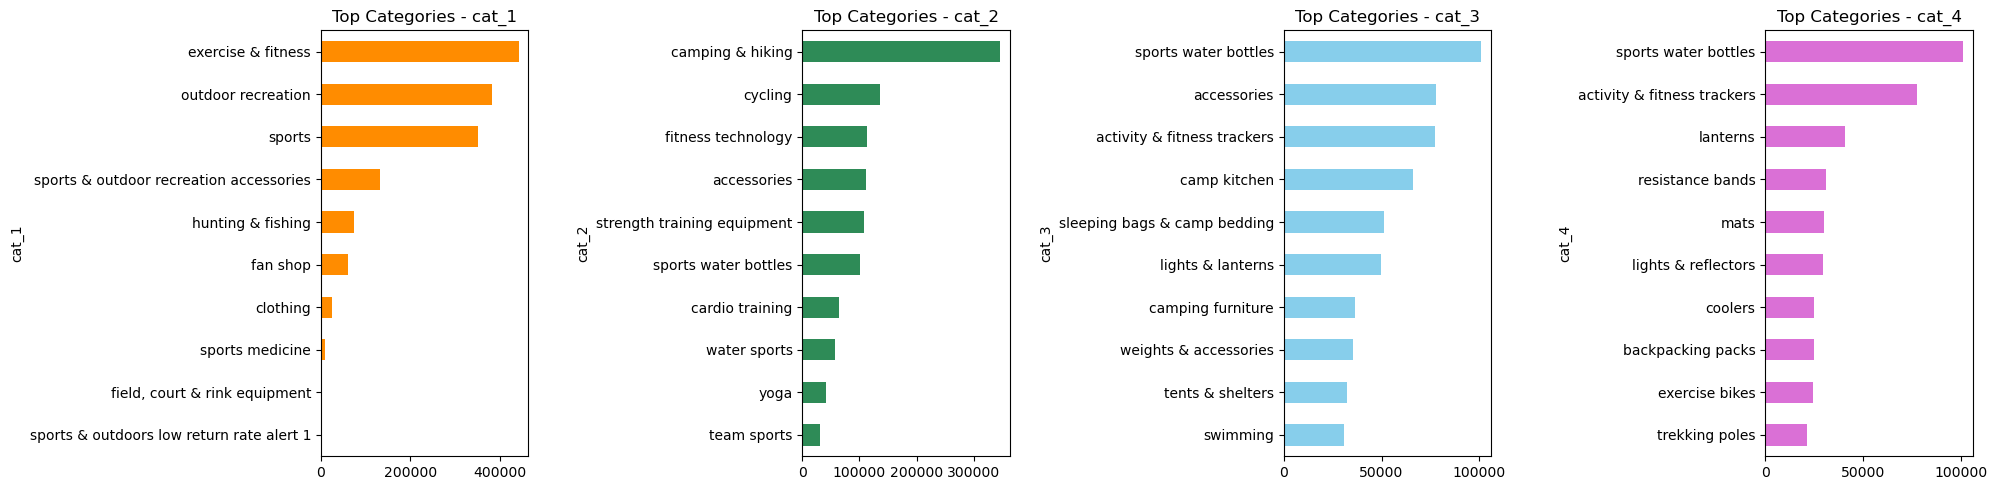

In [66]:
# Create 1 row with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Top categories in cat_1
df['cat_1'].value_counts(dropna=False).head(10).plot(
    kind='barh', ax=axes[0], color='darkorange'
)
axes[0].set_title("Top Categories - cat_1")
axes[0].invert_yaxis()

# Top categories in cat_2
df['cat_2'].value_counts(dropna=False).head(10).plot(
    kind='barh', ax=axes[1], color='seagreen'
)
axes[1].set_title("Top Categories - cat_2")
axes[1].invert_yaxis()

# Top categories in cat_3
df['cat_3'].value_counts(dropna=False).head(10).plot(
    kind='barh', ax=axes[2], color='skyblue'
)
axes[2].set_title("Top Categories - cat_3")
axes[2].invert_yaxis()

# Top categories in cat_4
df['cat_4'].value_counts(dropna=False).head(10).plot(
    kind='barh', ax=axes[3], color='orchid'
)
axes[3].set_title("Top Categories - cat_4")
axes[3].invert_yaxis()

plt.tight_layout()
plt.show()

### Based on the above plot, cold start basket collection will be:
1. camping & hiking
2. cycling
3. fitness technology
4. strength training equipment
5. cardio training

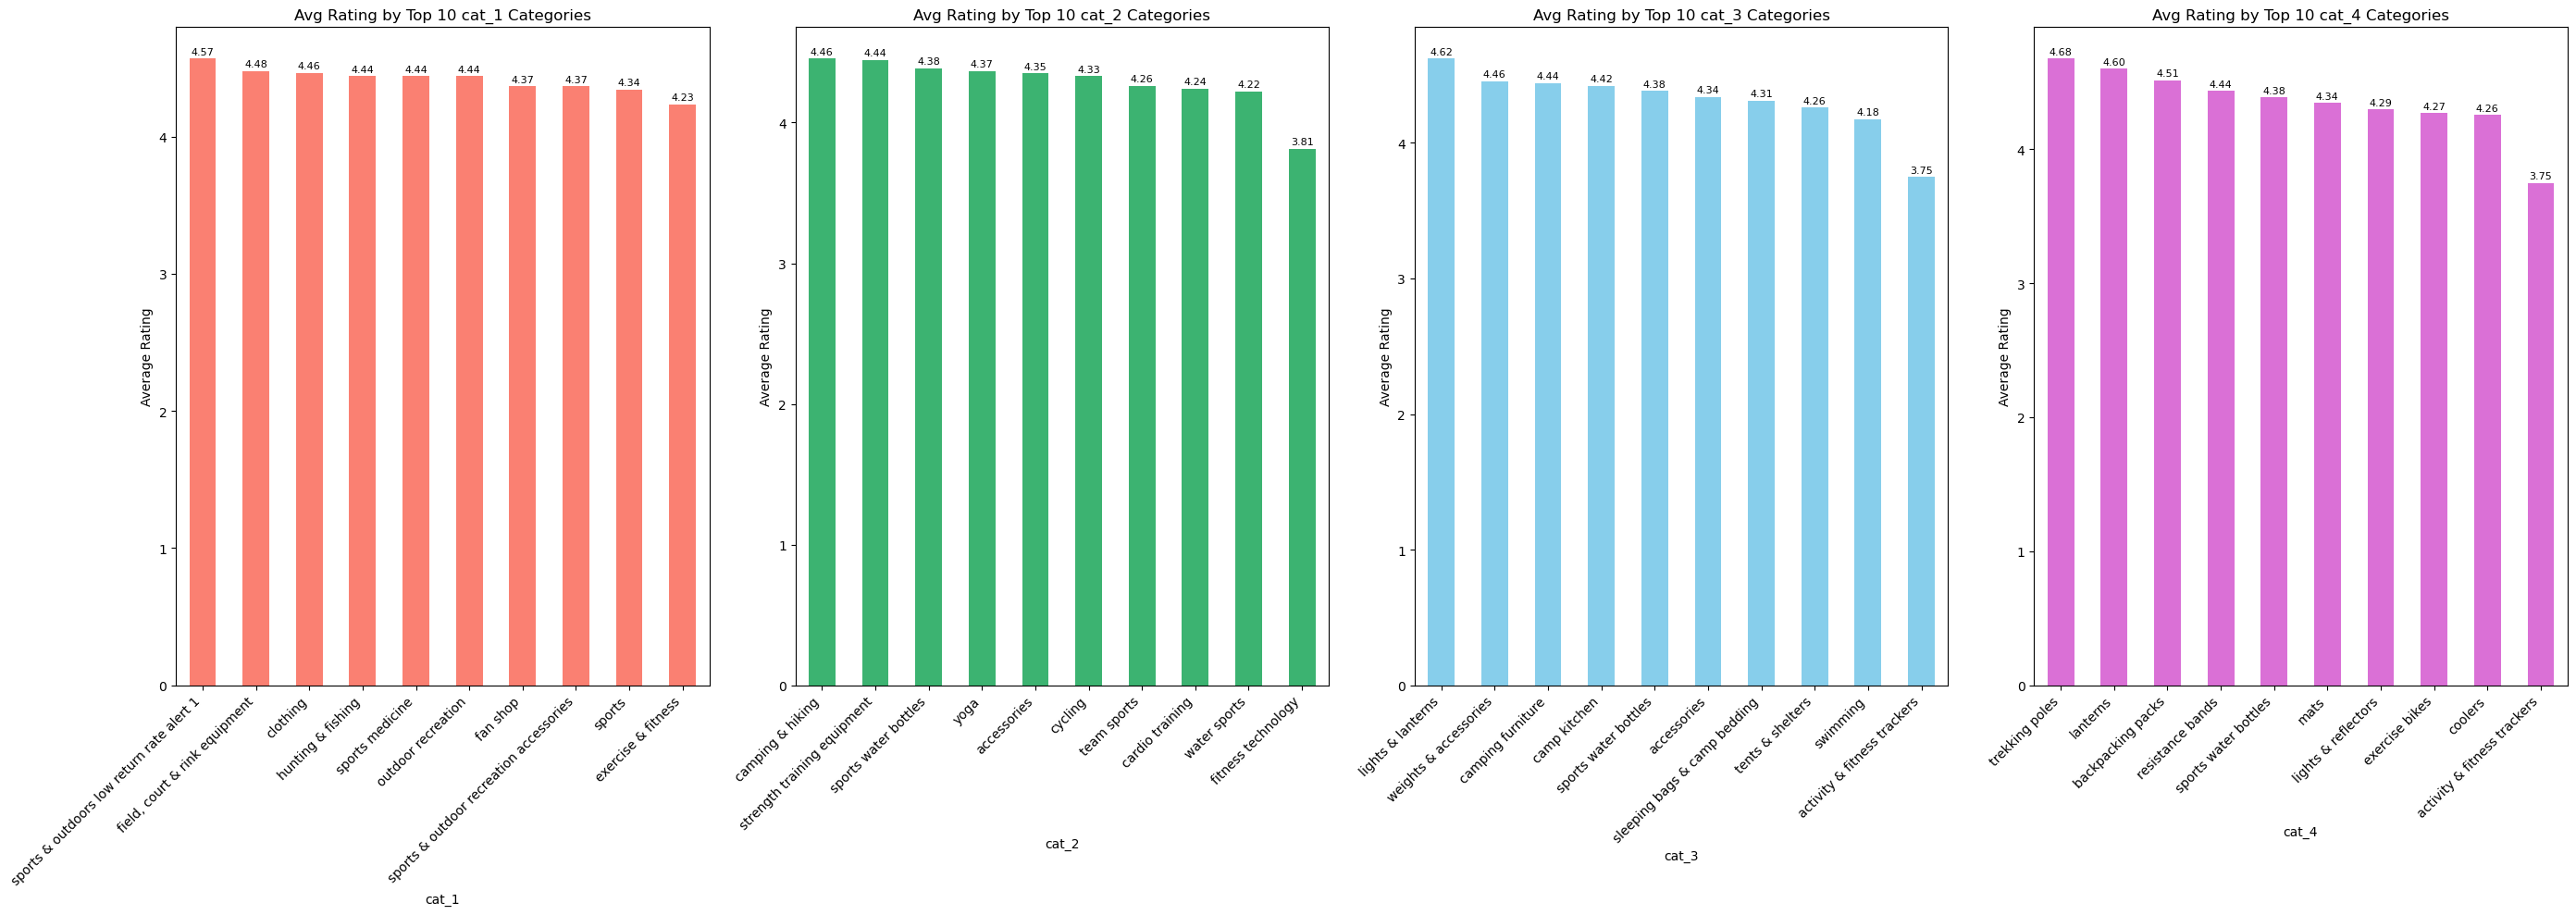

In [70]:
def plot_top10_avg_rating_by_category(cat_col, color, ax):
    top_10 = df[cat_col].value_counts().head(10).index
    avg_rating = (
        df[df[cat_col].isin(top_10)]
        .groupby(cat_col)['rating']
        .mean()
        .sort_values(ascending=False)
    )
    
    avg_rating.plot(kind='bar', color=color, ax=ax)
    ax.set_title(f"Avg Rating by Top 10 {cat_col} Categories")
    ax.set_ylabel("Average Rating")
    ax.set_xlabel(cat_col)
    ax.set_xticklabels(avg_rating.index, rotation=45, ha='right')

    for i, v in enumerate(avg_rating.values):
        ax.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=8)

# Create subplots in a single horizontal row
fig, axes = plt.subplots(1, 4, figsize=(28, 10))  # Wider width to fit 4 plots

# Plot each category level
plot_top10_avg_rating_by_category('cat_1', 'salmon', axes[0])
plot_top10_avg_rating_by_category('cat_2', 'mediumseagreen', axes[1])
plot_top10_avg_rating_by_category('cat_3', 'skyblue', axes[2])
plot_top10_avg_rating_by_category('cat_4', 'orchid', axes[3])

plt.tight_layout()
plt.show()


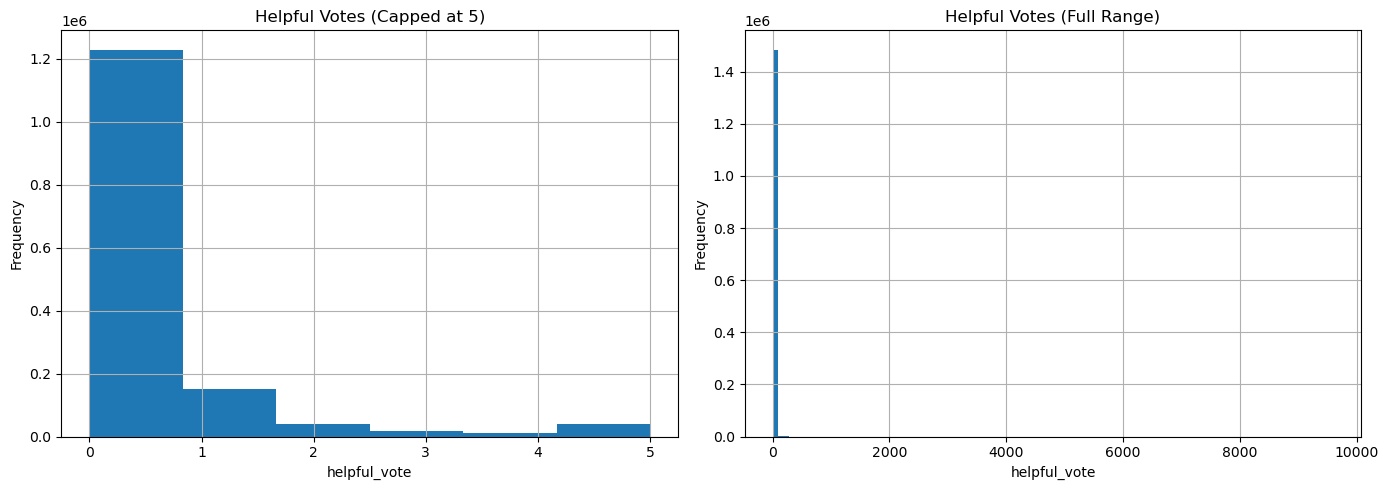

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Clipped at 5
df['helpful_vote'].clip(upper=5).hist(bins=6, ax=axes[0])
axes[0].set_title("Helpful Votes (Capped at 5)")
axes[0].set_xlabel("helpful_vote")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Plot 2: Unclipped
df['helpful_vote'].hist(bins=100, ax=axes[1])
axes[1].set_title("Helpful Votes (Full Range)")
axes[1].set_xlabel("helpful_vote")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

plt.tight_layout()
plt.show()


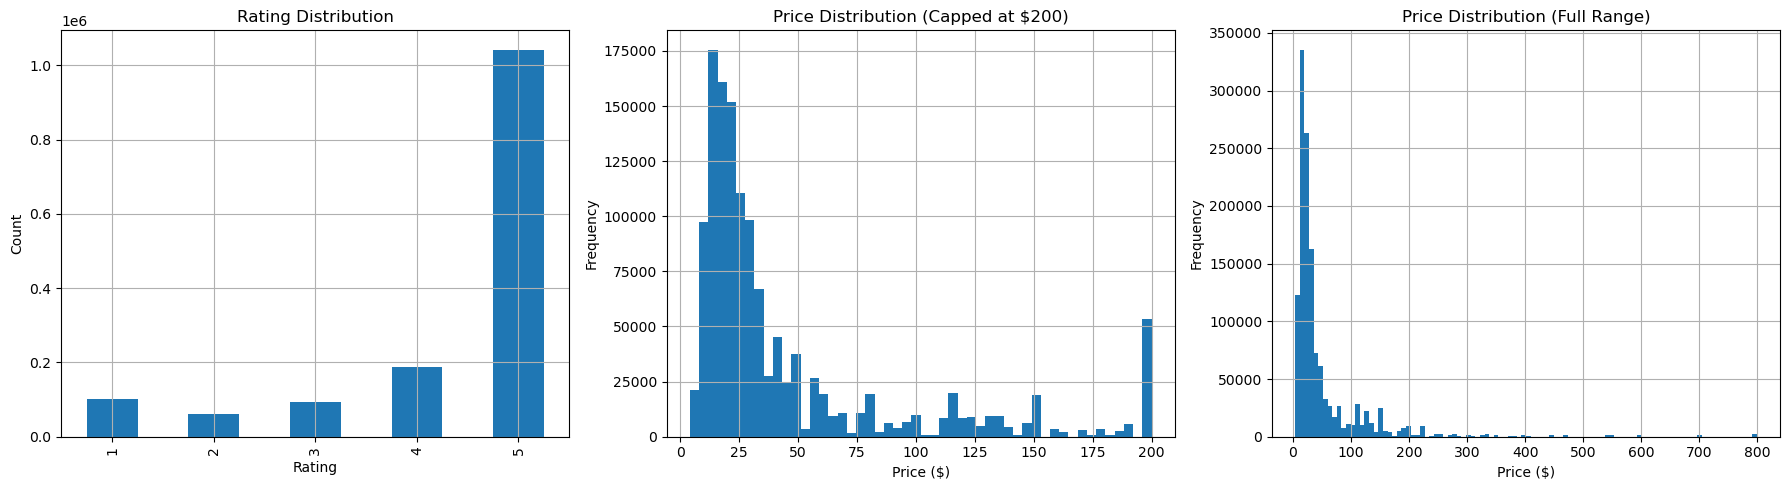

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Rating distribution
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title("Rating Distribution")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Count")
axes[0].grid(True)

# Plot 2: Price (clipped at $200)
df['price'].clip(upper=200).hist(bins=50, ax=axes[1])
axes[1].set_title("Price Distribution (Capped at $200)")
axes[1].set_xlabel("Price ($)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Plot 3: Price (full range)
df['price'].hist(bins=100, ax=axes[2])
axes[2].set_title("Price Distribution (Full Range)")
axes[2].set_xlabel("Price ($)")
axes[2].set_ylabel("Frequency")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [73]:
df.head()

,rating,title_review,text,parent_asin,user_id,helpful_vote,title_meta,price,store,features_clean,description_clean,timestamp_utc,category_depth,verified_purchase_flag,cat_1,cat_2,cat_3,cat_4,price_log,helpful_vote_clipped,avg_rating_parent
0,1,falls off during runs / flawed design / weak...,let's start with the positives. it is a nice ...,B0B7QYSGRP,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,10,"running buddy magnetic buddy pouch, beltess, c...",19.99,running buddy,compatibility: the small buddy pouch measures ...,,2015-05-28 15:57:03+00:00,4,1,sports,running,waist packs,waist packs,3.044046,5,4.5
1,1,only 1 worked correctly,i ordered this set right before my camping tri...,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1,"vont led camping lantern, led lanterns, suitab...",14.38,vont,bright & lasting - equipped with 30 crazy brig...,,2020-11-11 07:10:55.679000+00:00,6,1,outdoor recreation,camping & hiking,lights & lanterns,lanterns,2.733068,1,4.7
2,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,0,ativafit exercise bike foldable fitness indoor...,139.99,ativafit,digital monitor shows your data - monitor your...,"ativafit indoor exercise bike, foldable, magne...",2020-05-17 22:40:46.636000+00:00,4,1,exercise & fitness,cardio training,exercise bikes,exercise bikes,4.948689,0,4.3
3,5,great for working out !,they are great for working out! not only that ...,B0B8T4M8KY,AFEMUMKLC4W5PVHEALEWMC25AOJQ,0,balancefrom puzzle exercise mat with eva foam ...,129.99,balancefrom,with double sided high density eva foam non-sl...,,2020-04-02 15:14:36.191000+00:00,4,1,exercise & fitness,accessories,exercise equipment mats,exercise equipment mats,4.875121,0,4.4
4,5,great little tent,"i love the alps tent. it is light, super easy...",B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,0,alps mountaineering lynx 1-person backpacking ...,109.99,alps mountaineering,100% polyester imported great backpacking tent,the lynx 1 is loaded with features and is grea...,2019-09-01 01:46:16.061000+00:00,5,0,outdoor recreation,camping & hiking,tents & shelters,tents,4.709440,0,4.7


In [74]:
# df to be filtered with only rows containing the top 5 categories
top_cat2 = [
    "camping & hiking",
    "cycling",
    "fitness technology",
    "strength training equipment",
    "cardio training"
]

# Filter the DataFrame
top_5_df = df[df['cat_2'].isin(top_cat2)].copy()

# Output the result
print(f"Filtered top_5_df created with {top_5_df.shape[0]:,} rows and {top_5_df.shape[1]} columns.")


Filtered top_5_df created with 767,684 rows and 21 columns.


In [75]:
top_5_df.head()

,rating,title_review,text,parent_asin,user_id,helpful_vote,title_meta,price,store,features_clean,description_clean,timestamp_utc,category_depth,verified_purchase_flag,cat_1,cat_2,cat_3,cat_4,price_log,helpful_vote_clipped,avg_rating_parent
1,1,only 1 worked correctly,i ordered this set right before my camping tri...,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1,"vont led camping lantern, led lanterns, suitab...",14.38,vont,bright & lasting - equipped with 30 crazy brig...,,2020-11-11 07:10:55.679000+00:00,6,1,outdoor recreation,camping & hiking,lights & lanterns,lanterns,2.733068,1,4.7
2,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,0,ativafit exercise bike foldable fitness indoor...,139.99,ativafit,digital monitor shows your data - monitor your...,"ativafit indoor exercise bike, foldable, magne...",2020-05-17 22:40:46.636000+00:00,4,1,exercise & fitness,cardio training,exercise bikes,exercise bikes,4.948689,0,4.3
4,5,great little tent,"i love the alps tent. it is light, super easy...",B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,0,alps mountaineering lynx 1-person backpacking ...,109.99,alps mountaineering,100% polyester imported great backpacking tent,the lynx 1 is loaded with features and is grea...,2019-09-01 01:46:16.061000+00:00,5,0,outdoor recreation,camping & hiking,tents & shelters,tents,4.709440,0,4.7
5,5,very cute,"bought this for my son’s birthday, super cute ...",B07Z6Y87XH,AEGEQO4R6APZMUYEYT2VGJ3BKKAQ,0,raskullz mohawk toddler 3+ and child 5+ helmets,35.49,raskullz,design - kids love the red bendable 3d rubber ...,,2020-11-16 19:07:19.645000+00:00,5,1,sports,cycling,kids' bikes & accessories,kids' helmets,3.597038,0,4.7
7,5,my pooches love it!,we purchased this two person tent for our dogs...,B09HRDWXCK,AEDAZ44DKSCBHMY4VOCU6Z7DWM7A,3,2-person camping tent – includes rain fly and ...,45.94,wakeman,100% polyester imported 2 person tent – this l...,,2016-02-24 17:58:45+00:00,5,1,outdoor recreation,camping & hiking,tents & shelters,tents,3.848870,3,3.6


In [77]:
# Total number of rows
total_rows = len(top_5_df)
print(f"Total rows in top_5_df: {total_rows:,}")

# Total number of rows
total_rows = len(df)
print(f"Total rows in df: {total_rows:,}")

Total rows in top_5_df: 767,684
Total rows in df: 1,487,892


# Export 2 files
- Final_Table (labelled as: df) - total of 1,487,892 (backup in case phase 2 team needs more than 5 categories)
- 5_Category_Final_Table (labelled as: top_5_df) - 767,684

### Please note the nan values existing across these columns - to decide if drop rows, imputation etc. to proceed with model development:

In [79]:
# Compute missing values for df
df_na = df.isna().sum().reset_index()
df_na.columns = ['Column', 'NaN in df']
df_na = df_na[df_na['NaN in df'] > 0]  # optional: show only columns with NaNs

# Compute missing values for top_5_df
top_5_na = top_5_df.isna().sum().reset_index()
top_5_na.columns = ['Column', 'NaN in top_5_df']
top_5_na = top_5_na[top_5_na['NaN in top_5_df'] > 0]  # optional: show only columns with NaNs

# Display both
print("Missing Values in df:")
display(df_na)

print("\nMissing Values in top_5_df:")
display(top_5_na)

Missing Values in df:


,Column,NaN in df
1,title_review,120
2,text,767
7,price,162346
8,store,9366
15,cat_2,11103
16,cat_3,11103
17,cat_4,11103
18,price_log,162346



Missing Values in top_5_df:


,Column,NaN in top_5_df
1,title_review,61
2,text,407
7,price,92334
8,store,7370
18,price_log,92334


In [80]:
output_path = "D:/amzn_two_final_tables"

In [84]:
# Export top 5 category subset dataset
top_5_df.to_parquet(f"{output_path}/5_category_final_table_(767,684 rows).parquet", index=False)

# Export full cleaned dataset - backup for phase 2 team in case you all need more categories
df.to_parquet(f"{output_path}/final_table_(1,487,892 rows).parquet", index=False)

print("Export completed: final_table.parquet and 5_category_final_table.parquet saved")

Export completed: final_table.parquet and 5_category_final_table.parquet saved


In [85]:
new_1 = pd.read_parquet('D:/amzn_two_final_tables/5_category_final_table_(767,684 rows).parquet')
new_1.head()

,rating,title_review,text,parent_asin,user_id,helpful_vote,title_meta,price,store,features_clean,description_clean,timestamp_utc,category_depth,verified_purchase_flag,cat_1,cat_2,cat_3,cat_4,price_log,helpful_vote_clipped,avg_rating_parent
0,1,only 1 worked correctly,i ordered this set right before my camping tri...,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1,"vont led camping lantern, led lanterns, suitab...",14.38,vont,bright & lasting - equipped with 30 crazy brig...,,2020-11-11 07:10:55.679000+00:00,6,1,outdoor recreation,camping & hiking,lights & lanterns,lanterns,2.733068,1,4.7
1,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,0,ativafit exercise bike foldable fitness indoor...,139.99,ativafit,digital monitor shows your data - monitor your...,"ativafit indoor exercise bike, foldable, magne...",2020-05-17 22:40:46.636000+00:00,4,1,exercise & fitness,cardio training,exercise bikes,exercise bikes,4.948689,0,4.3
2,5,great little tent,"i love the alps tent. it is light, super easy...",B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,0,alps mountaineering lynx 1-person backpacking ...,109.99,alps mountaineering,100% polyester imported great backpacking tent,the lynx 1 is loaded with features and is grea...,2019-09-01 01:46:16.061000+00:00,5,0,outdoor recreation,camping & hiking,tents & shelters,tents,4.709440,0,4.7
3,5,very cute,"bought this for my son’s birthday, super cute ...",B07Z6Y87XH,AEGEQO4R6APZMUYEYT2VGJ3BKKAQ,0,raskullz mohawk toddler 3+ and child 5+ helmets,35.49,raskullz,design - kids love the red bendable 3d rubber ...,,2020-11-16 19:07:19.645000+00:00,5,1,sports,cycling,kids' bikes & accessories,kids' helmets,3.597038,0,4.7
4,5,my pooches love it!,we purchased this two person tent for our dogs...,B09HRDWXCK,AEDAZ44DKSCBHMY4VOCU6Z7DWM7A,3,2-person camping tent – includes rain fly and ...,45.94,wakeman,100% polyester imported 2 person tent – this l...,,2016-02-24 17:58:45+00:00,5,1,outdoor recreation,camping & hiking,tents & shelters,tents,3.848870,3,3.6


In [86]:
new_2 = pd.read_parquet('D:/amzn_two_final_tables/final_table_(1,487,892 rows).parquet')
new_2.head()

,rating,title_review,text,parent_asin,user_id,helpful_vote,title_meta,price,store,features_clean,description_clean,timestamp_utc,category_depth,verified_purchase_flag,cat_1,cat_2,cat_3,cat_4,price_log,helpful_vote_clipped,avg_rating_parent
0,1,falls off during runs / flawed design / weak...,let's start with the positives. it is a nice ...,B0B7QYSGRP,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,10,"running buddy magnetic buddy pouch, beltess, c...",19.99,running buddy,compatibility: the small buddy pouch measures ...,,2015-05-28 15:57:03+00:00,4,1,sports,running,waist packs,waist packs,3.044046,5,4.5
1,1,only 1 worked correctly,i ordered this set right before my camping tri...,B09LW2KHPM,AGO25X54UAIXSKHOAH4SG2VUDUNA,1,"vont led camping lantern, led lanterns, suitab...",14.38,vont,bright & lasting - equipped with 30 crazy brig...,,2020-11-11 07:10:55.679000+00:00,6,1,outdoor recreation,camping & hiking,lights & lanterns,lanterns,2.733068,1,4.7
2,5,lightweight and quiet,this bike is nice and simple. easy to build an...,B0BTDLFXSL,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,0,ativafit exercise bike foldable fitness indoor...,139.99,ativafit,digital monitor shows your data - monitor your...,"ativafit indoor exercise bike, foldable, magne...",2020-05-17 22:40:46.636000+00:00,4,1,exercise & fitness,cardio training,exercise bikes,exercise bikes,4.948689,0,4.3
3,5,great for working out !,they are great for working out! not only that ...,B0B8T4M8KY,AFEMUMKLC4W5PVHEALEWMC25AOJQ,0,balancefrom puzzle exercise mat with eva foam ...,129.99,balancefrom,with double sided high density eva foam non-sl...,,2020-04-02 15:14:36.191000+00:00,4,1,exercise & fitness,accessories,exercise equipment mats,exercise equipment mats,4.875121,0,4.4
4,5,great little tent,"i love the alps tent. it is light, super easy...",B09W4W9JB5,AGOSUQAEYTC5A6YDIJ7X5ZFAOSIQ,0,alps mountaineering lynx 1-person backpacking ...,109.99,alps mountaineering,100% polyester imported great backpacking tent,the lynx 1 is loaded with features and is grea...,2019-09-01 01:46:16.061000+00:00,5,0,outdoor recreation,camping & hiking,tents & shelters,tents,4.709440,0,4.7
